This example is inspired in the seminal paper: Kinetic Phase Transitions in
an Irreversible Surface-Reaction Model by Robert M. Ziff, Erdagon Gulari,
and Yoav Barshad in 1986
[Phys. Rev. Lett. 56, 25](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.56.2553>).
While the model leaves out many important steps of the real system, it exhibits
interesting steady-state off-equilibrium behavior and two types of phase
transitions, which actually occur in real systems. Please refer to the original
paper for more details. In this example, we will analyze the effect of changing
the composition of the gas phase, namely partial pressures for $O_2$ and $CO$,
in the $CO_2$ Turnover frequency (TOF). At variance with the example
**Phase Transitions in the ZGB model**, here we extend the dynamics up to
reaching the system's steady state for each gas phase composition value. Most
of the code is the same, except for the section regarding the setup of the
steady state calculation.

First, we import all packages we need:

In [1]:
import multiprocessing
import numpy
import scm.plams
import scm.pyzacros as pz
import scm.pyzacros.models

Then, we initialize the **pyZacros** environment:

In [2]:
scm.pyzacros.init()

PLAMS working folder: /home/aguirre/Develop/pyzacros/examples/ZiffGulariBarshad/plams_workdir


On a typical laptop, this calculation should take no more than 10 min to complete.
Here we illustrate how to run several parallel Zacros calculations. We'll use
the ``plams.JobRunner`` class, which easily allows us to run as many parallel
instances as we request. In this case, we choose to use the maximum number of
simultaneous processes (``maxjobs``) equal to the number of processors in the
machine. Additionally, by setting ``nproc =  1`` we establish that only one
processor will be used for each zacros instance. 

In [3]:
maxjobs = multiprocessing.cpu_count()
scm.plams.config.default_jobrunner = scm.plams.JobRunner(parallel=True, maxjobs=maxjobs)
scm.plams.config.job.runscript.nproc = 1
print('Running up to {} jobs in parallel simultaneously'.format(maxjobs))

Running up to 8 jobs in parallel simultaneously


Now, we initialize our Ziff-Gulari-Barshad model, which by luck is available as a
predefined model in pyZacros,

In [4]:
zgb = pz.models.ZiffGulariBarshad()

Then, we must set up a ``ZacrosParametersScanJob`` calculation, which will allow
us to scan the molar fraction of $CO$ as a parameter. However, this calculation
requires the definition of a ``ZacrosSteadyStateJob``, that in turns requires a
``ZacrosJob``. So, We will go through them one at a time:

**1. Setting up the ZacrosJob**

For ``ZacrosJob``, all parameters are set using a ``Setting`` object. To begin,
we define the physical parameters: ``temperature`` (in K), and ``pressure``
(in bar). The calculation parameters are then set: ``species numbers`` (in s)
determines how frequently information about the number of gas and surface species
will be stored, ``max time`` (in s) specifies the maximum allowed simulated time,
and "random seed" specifies the random seed to make the calculation precisely
reproducible. Keep in mind that ``max time`` defines the calculation's stopping
criterion, and it is the parameter that will be controlled later to achieve the
steady-state configuration. Finally, we create the ``ZacrosJob``, which uses the
parameters we just defined as well as the Ziff-Gulari-Barshad model's lattice,
mechanism, and cluster expansion. Notice we do not run this job, we use it as a
reference for the steady-state calculation described below.

In [5]:
z_sett = pz.Settings()
z_sett.temperature = 500.0
z_sett.pressure = 1.0
z_sett.max_time = 10.0
z_sett.species_numbers = ('time', 0.1)
z_sett.random_seed = 953129

z_job = pz.ZacrosJob( settings=z_sett, lattice=zgb.lattice,
                      mechanism=zgb.mechanism,
                      cluster_expansion=zgb.cluster_expansion )

**2. Setting up the ZacrosSteadyStateJob**

We also need to create a ``Setting`` object for ``ZacrosJob`` There, we ask for a
steady-state configuration using a TOFs calculation with a 96% confidence level
(``turnover frequency.confidence``), using four replicas to speed up the calculation
(``turnover frequency.nreplicas``); for more information, see example
**Ziff-Gulari-Barshad model: Steady State Conditions**.
The ``ZacrosSteadyStateJob.Parameters`` object allows to set the grid of maximum
times to explore in order to reach the steady state (``ss_params``). Finally, we
create ``ZacrosSteadyStateJob``, which references the ``ZacrosJob`` defined above
(``z_job``) as well as the ``Settings`` object and parameters we just defined:

In [6]:
ss_sett = pz.Settings()
ss_sett.turnover_frequency.nbatch = 20
ss_sett.turnover_frequency.confidence = 0.96
ss_sett.turnover_frequency.nreplicas = 4

ss_params = pz.ZacrosSteadyStateJob.Parameters()
ss_params.add( 'max_time', 'restart.max_time',
                   2*z_sett.max_time*( numpy.arange(10)+1 )**2 )

ss_job = pz.ZacrosSteadyStateJob( settings=ss_sett, reference=z_job,
                                  parameters=ss_params )

[27.01|11:36:27] JOB plamsjob Steady State Convergence: Using nbatch=20,confidence=0.96,ignore_nbatch=1,nreplicas=4


**3. Setting up the ZacrosParametersScanJob**

Although the ``ZacrosParametersScanJob`` does not require a ``Setting`` object,
it does require a ``ZacrosSteadyStateJob.Parameters`` object to specify which
parameters must be modified systematically. In this instance, all we need is a
dependent parameter, the $O_2$ molar fraction ``x_O2``, and an independent
parameter, the $CO$ molar fraction ``x_CO``, which ranges from 0.2 to 0.8 in steps
of 0.01. Keep in mind that the condition ``x_CO+x_O2=1`` must be met. These molar
fractions will be used internally to replace ``molar fraction.CO`` and
``molar fraction.O2`` in the Zacros input files. Then, using the
``ZacrosSteadyStateJob`` defined earlier (``ss job``) and the parameters we just
defined (``ps params``), we create the ``ZacrosParametersScanJob``: 

In [7]:
ps_params = pz.ZacrosParametersScanJob.Parameters()
ps_params.add( 'x_CO', 'molar_fraction.CO', numpy.arange(0.2, 0.8, 0.01) )
ps_params.add( 'x_O2', 'molar_fraction.O2', lambda params: 1.0-params['x_CO'] )

ps_job = pz.ZacrosParametersScanJob( reference=ss_job, parameters=ps_params )

[27.01|11:36:27] JOB ps_cond000 Steady State Convergence: Using nbatch=20,confidence=0.96,ignore_nbatch=1,nreplicas=4
[27.01|11:36:27] JOB ps_cond001 Steady State Convergence: Using nbatch=20,confidence=0.96,ignore_nbatch=1,nreplicas=4
[27.01|11:36:27] JOB ps_cond002 Steady State Convergence: Using nbatch=20,confidence=0.96,ignore_nbatch=1,nreplicas=4
[27.01|11:36:27] JOB ps_cond003 Steady State Convergence: Using nbatch=20,confidence=0.96,ignore_nbatch=1,nreplicas=4
[27.01|11:36:27] JOB ps_cond004 Steady State Convergence: Using nbatch=20,confidence=0.96,ignore_nbatch=1,nreplicas=4
[27.01|11:36:27] JOB ps_cond005 Steady State Convergence: Using nbatch=20,confidence=0.96,ignore_nbatch=1,nreplicas=4
[27.01|11:36:27] JOB ps_cond006 Steady State Convergence: Using nbatch=20,confidence=0.96,ignore_nbatch=1,nreplicas=4
[27.01|11:36:27] JOB ps_cond007 Steady State Convergence: Using nbatch=20,confidence=0.96,ignore_nbatch=1,nreplicas=4
[27.01|11:36:27] JOB ps_cond008 Steady State Convergence

The parameters scan calculation setup is ready. Therefore, we can start it
by invoking the function ``run()``, which will provide access to the results via the
``results`` variable after it has been completed. The sentence involving the method
``ok()``, verifies that the calculation was successfully executed, and waits
for the completion of every executed thread. This step should take less than 10 mins!

In [8]:
results = ps_job.run()

if not results.job.ok():
    print('Something went wrong!')    

[27.01|11:36:27] JOB plamsjob STARTED
[27.01|11:36:27] Waiting for job plamsjob to finish
[27.01|11:36:27] JOB plamsjob RUNNING
[27.01|11:36:27] JOB plamsjob/ps_cond000 STARTED
[27.01|11:36:27] JOB plamsjob/ps_cond001 STARTED
[27.01|11:36:27] JOB plamsjob/ps_cond002 STARTED
[27.01|11:36:27] JOB plamsjob/ps_cond000 RUNNING
[27.01|11:36:27] JOB plamsjob/ps_cond003 STARTED
[27.01|11:36:27] JOB plamsjob/ps_cond001 RUNNING
[27.01|11:36:27] JOB ps_cond000/ss_iter000_rep000 Steady State: NEW
[27.01|11:36:27] JOB plamsjob/ps_cond004 STARTED
[27.01|11:36:27] JOB ps_cond001/ss_iter000_rep000 Steady State: NEW
[27.01|11:36:27] JOB ps_cond000/ss_iter000_rep001 Steady State: NEW
[27.01|11:36:27] JOB plamsjob/ps_cond002 RUNNING
[27.01|11:36:27] JOB plamsjob/ps_cond005 STARTED
[27.01|11:36:27] JOB ps_cond001/ss_iter000_rep001 Steady State: NEW
[27.01|11:36:27] JOB ps_cond000/ss_iter000_rep002 Steady State: NEW
[27.01|11:36:27] JOB ps_cond002/ss_iter000_rep000 Steady State: NEW
[27.01|11:36:27] JOB pl

If the execution got up to this point, everything worked as expected. Hooray!

Finally, in the following lines, we just nicely print the results in a table. See
the API documentation to learn more about how the ``results`` object is structured,
and the available methods. In this case, we use the ``turnover_frequency()`` and
``average_coverage()`` methods to get the TOF for the gas species and average coverage
for the surface species, respectively. Regarding the latter one, we use the last 10
steps in the simulation to calculate the average coverages. Notably, the loop iterates
over the internal indices (``results.indices()``) of each condition. ``i`` is simply
a sequential number for each condition in this case, but ``idx`` is an id for the
corresponding child job. This id may be a complex object for n-dimension (n>1) scanning
parameters, so if you want to access the properties of one of the child jobs, we
recommend using a loop like the one we use here. In the lines that follow, we use this
``idx`` to get the maximum time that the simulation required to achieve the steady
state for that specific composition ("max time"). 

In [9]:
x_CO = []
ac_O = []
ac_CO = []
TOF_CO2 = []
max_time = []

results_dict = results.turnover_frequency()
results_dict = results.average_coverage( last=10, update=results_dict )

for i,idx in enumerate(results.indices()):
    x_CO.append( results_dict[i]['x_CO'] )
    ac_O.append( results_dict[i]['average_coverage']['O*'] )
    ac_CO.append( results_dict[i]['average_coverage']['CO*'] )
    TOF_CO2.append( results_dict[i]['turnover_frequency']['CO2'] )
    max_time.append( results.children_results( child_id=idx ).history( pos=-1 )['max_time'] )

print( "-----------------------------------------------------------" )
print( "%4s"%"cond", "%8s"%"x_CO", "%10s"%"ac_O", "%10s"%"ac_CO", "%12s"%"TOF_CO2", "%10s"%"max_time" )
print( "-----------------------------------------------------------" )
for i in range(len(x_CO)):
    print( "%4d"%i, "%8.2f"%x_CO[i], "%10.6f"%ac_O[i], "%10.6f"%ac_CO[i], "%12.6f"%TOF_CO2[i], "%10.3f"%max_time[i] )

-----------------------------------------------------------
cond     x_CO       ac_O      ac_CO      TOF_CO2   max_time
-----------------------------------------------------------
   0     0.20   0.999250   0.000000     0.002567     20.000
   1     0.21   0.999900   0.000000     0.000000     20.000
   2     0.22   0.999590   0.000000     0.000700     20.000
   3     0.23   0.999130   0.000000     0.002100     20.000
   4     0.24   0.998630   0.000000     0.004267     20.000
   5     0.25   0.998720   0.000000     0.003267     20.000
   6     0.26   0.998760   0.000000     0.003267     20.000
   7     0.27   0.998920   0.000000     0.003233     20.000
   8     0.28   0.998090   0.000000     0.007100     20.000
   9     0.29   1.000000   0.000000     0.003241     80.000
  10     0.30   1.000000   0.000000     0.004973     80.000
  11     0.31   1.000000   0.000000     0.005157     80.000
  12     0.32   0.992570   0.000020     0.026933     20.000
  13     0.33   1.000000   0.000000     

The above results are the final aim of the calculation. However, we
can take advantage of python libraries to visualize them. Here, we
use matplotlib. Please check the matplotlib documentation for more
details at [matplotlib](https://matplotlib.org/). The following lines
of code allow visualizing the effect of changing the $CO$ partial
pressure on the average coverage of $O*$ and $CO*$ and the production
rate of $CO_2$:

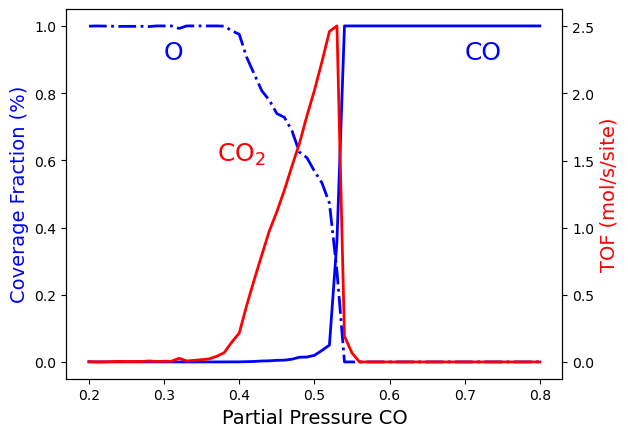

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = plt.axes()
ax.set_xlabel('Partial Pressure CO', fontsize=14)
ax.set_ylabel("Coverage Fraction (%)", color="blue", fontsize=14)
ax.plot(x_CO, ac_O, color="blue", linestyle="-.", lw=2, zorder=1)
ax.plot(x_CO, ac_CO, color="blue", linestyle="-", lw=2, zorder=2)
plt.text(0.3, 0.9, 'O', fontsize=18, color="blue")
plt.text(0.7, 0.9, 'CO', fontsize=18, color="blue")

ax2 = ax.twinx()
ax2.set_ylabel("TOF (mol/s/site)",color="red", fontsize=14)
ax2.plot(x_CO, TOF_CO2, color="red", lw=2, zorder=5)
plt.text(0.37, 1.5, 'CO$_2$', fontsize=18, color="red")

plt.show()

As shown in the Figure, we also found three regions involving two phase
transitions, which are similar to the ones obtained in the example
**Phase Transitions in the ZGB model**, where we did not converge the
calculation up to the steady-state condition. However, in this case,
the first transition, corresponding to the limit of $O^*$ poisoning,
occurs at ``x_CO=0.40`` rather than ``x_CO=0.32``, and the second
transition, corresponding to the beginning of CO poisoning, occurs
roughly at the same value ``x_CO=0.55`` but as a more abrupt change.

Now, we can close the pyZacros environment:

In [11]:
scm.pyzacros.finish()

[27.01|11:44:30] PLAMS run finished. Goodbye
